In [454]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler


# importing data

In [455]:
df = pd.read_csv('dirty_taxi_data.csv', parse_dates=['pickup_datetime'])

In [456]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-01-16 20:06:00.000000168,3.3,2010-01-16 20:06:00 UTC,-73.953323,40.778532,-73.953375,40.772505,error_1.0
1,2010-09-22 23:21:00.00000065,6.5,2010-09-22 23:21:00 UTC,-73.985542,40.738333,-74.003350,40.738935,1.0
2,2013-10-17 18:40:14.0000001,5.0,2013-10-17 18:40:14 UTC,-73.999945,40.718097,-73.999239,40.723103,1.0
3,2015-06-09 19:39:42.0000009,40.5,2015-06-09 19:39:42 UTC,-73.974533,40.756237,-73.923149,40.867210,1.0
4,2012-05-01 07:16:59.0000001,7.7,2012-05-01 07:16:59 UTC,-73.952835,40.786351,-73.974022,40.762765,1.0


# check for data

In [457]:
df.shape

(115000, 8)

In [458]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115000 entries, 0 to 114999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                115000 non-null  object 
 1   fare_amount        92160 non-null   float64
 2   pickup_datetime    115000 non-null  object 
 3   pickup_longitude   115000 non-null  float64
 4   pickup_latitude    115000 non-null  float64
 5   dropoff_longitude  115000 non-null  float64
 6   dropoff_latitude   115000 non-null  float64
 7   passenger_count    93074 non-null   object 
dtypes: float64(5), object(3)
memory usage: 7.0+ MB


In [459]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,92160.000000,115000.000000,115000.000000,115000.000000,115000.000000
mean,16.431745,-72.559159,39.946204,-72.566149,39.939186
std,32.339641,10.650615,6.020752,10.218077,11.215051
min,-25.000000,-736.400000,-74.008970,-90.239125,-3114.304848
25%,6.100000,-73.992103,40.734890,-73.991481,40.734044
50%,8.500000,-73.981890,40.752672,-73.980078,40.753122
75%,13.700000,-73.967190,40.767137,-73.963695,40.768010
max,1456.600000,40.808197,90.016667,40.814702,407.000000


In [460]:
df.duplicated().sum()

np.int64(10217)

In [461]:
df.isna().sum()

key                      0
fare_amount          22840
pickup_datetime          0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
passenger_count      21926
dtype: int64

# Data cleaning

In [462]:
df.drop_duplicates(inplace=True)

In [463]:
mean_value = df['fare_amount'].mean() 

df['fare_amount'].fillna(value=mean_value, inplace=True) 

/var/folders/cc/x70s24gx40zg_y7gzcpvs4400000gn/T/ipykernel_1335/192695924.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fare_amount'].fillna(value=mean_value, inplace=True)


In [464]:
df.dropna(inplace=True)

In [465]:
df = df[df["fare_amount"]>0]

In [466]:
df.shape

(84920, 8)

In [467]:
df["passenger_count"].unique()

array(['error_1.0', '1.0', '2.0', '5.0', '6.0', 'error_3.0', 'error_2.0',
       '3.0', 'error_nan', '4.0', '0.0', 'error_4.0', 'error_5.0',
       'error_6.0', 'error_0.0'], dtype=object)

In [468]:
def to_numerique(string):
    number = string.replace('error_',"")
    return number

In [469]:
df["passenger_count"] = df["passenger_count"].agg(to_numerique)

df['passenger_count'] = pd.to_numeric(df['passenger_count'], errors='coerce')

/var/folders/cc/x70s24gx40zg_y7gzcpvs4400000gn/T/ipykernel_1335/182853679.py:1: FutureWarning: using <function to_numerique at 0x17c060ee0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df["passenger_count"] = df["passenger_count"].agg(to_numerique)


In [470]:
df.isna().sum()

key                     0
fare_amount             0
pickup_datetime         0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
passenger_count      1124
dtype: int64

In [471]:
df.fillna(1,inplace=True)
#df.dropna(inplace=True)

In [472]:
df[df["passenger_count"]==0].count()

key                  323
fare_amount          323
pickup_datetime      323
pickup_longitude     323
pickup_latitude      323
dropoff_longitude    323
dropoff_latitude     323
passenger_count      323
dtype: int64

In [473]:
df[df["passenger_count"]==0]=1

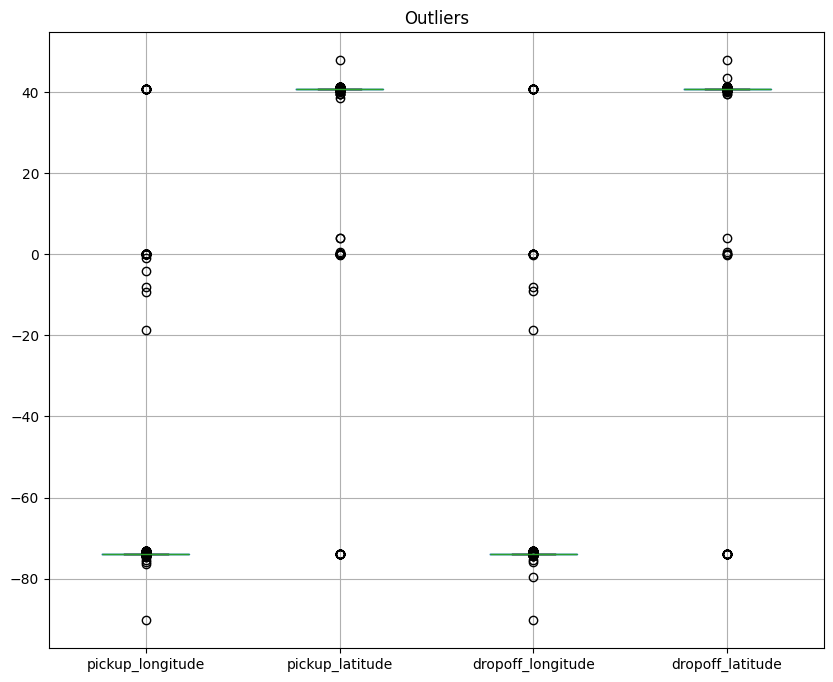

In [491]:
column = df[["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]]
plt.figure(figsize=(10, 8))
column.boxplot()
plt.title("Outliers")
plt.show()

In [475]:
df = df[(df["pickup_longitude"]>-200) & (df["dropoff_latitude"]<200)]

In [476]:
df.shape

(84916, 8)

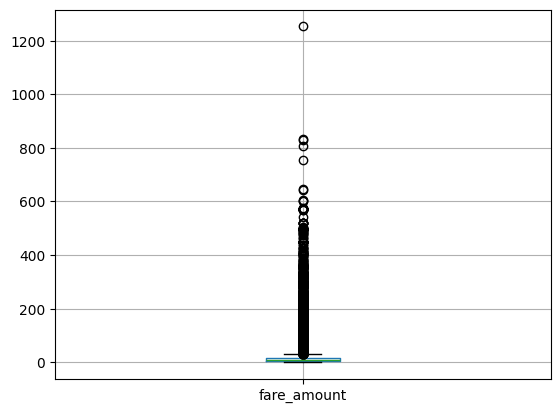

In [477]:
df[["fare_amount"]].boxplot()
plt.show()

In [478]:
df = df[(df['fare_amount']<15)]
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-01-16 20:06:00.000000168,3.3,2010-01-16 20:06:00 UTC,-73.953323,40.778532,-73.953375,40.772505,1.0
1,2010-09-22 23:21:00.00000065,6.5,2010-09-22 23:21:00 UTC,-73.985542,40.738333,-74.003350,40.738935,1.0
2,2013-10-17 18:40:14.0000001,5.0,2013-10-17 18:40:14 UTC,-73.999945,40.718097,-73.999239,40.723103,1.0
4,2012-05-01 07:16:59.0000001,7.7,2012-05-01 07:16:59 UTC,-73.952835,40.786351,-73.974022,40.762765,1.0
5,2014-01-26 20:28:28.0000003,4.0,2014-01-26 20:28:28 UTC,-73.956368,40.763146,-73.952015,40.769203,1.0
...,...,...,...,...,...,...,...,...
114966,2014-01-26 19:20:46.0000003,10.5,01-26-2014 19:20,-73.946040,40.773235,-73.961324,40.798675,1.0
114970,2011-03-27 10:41:00.000000154,5.3,2011-03-27,-73.988350,40.718748,-74.000517,40.725620,5.0
114975,2010-10-06 06:27:00.00000055,6.1,2010-10-06 06:27:00 UTC,-73.990563,40.750887,-73.974018,40.752912,1.0
114987,2011-10-07 22:39:00.000000134,9.7,2011-10-07 22:39:00 UTC,0.000000,0.000000,0.000000,0.000000,5.0


In [479]:
zero_row_values = (df['pickup_longitude'] == df['pickup_longitude'])&(df['dropoff_longitude']==df['dropoff_latitude'])

df = df[~zero_row_values]
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-01-16 20:06:00.000000168,3.3,2010-01-16 20:06:00 UTC,-73.953323,40.778532,-73.953375,40.772505,1.0
1,2010-09-22 23:21:00.00000065,6.5,2010-09-22 23:21:00 UTC,-73.985542,40.738333,-74.003350,40.738935,1.0
2,2013-10-17 18:40:14.0000001,5.0,2013-10-17 18:40:14 UTC,-73.999945,40.718097,-73.999239,40.723103,1.0
4,2012-05-01 07:16:59.0000001,7.7,2012-05-01 07:16:59 UTC,-73.952835,40.786351,-73.974022,40.762765,1.0
5,2014-01-26 20:28:28.0000003,4.0,2014-01-26 20:28:28 UTC,-73.956368,40.763146,-73.952015,40.769203,1.0
...,...,...,...,...,...,...,...,...
114965,2013-11-24 01:53:21.0000002,8.5,2013-11-24 01:53:21 UTC,-73.999000,40.734356,-73.973676,40.750713,1.0
114966,2014-01-26 19:20:46.0000003,10.5,01-26-2014 19:20,-73.946040,40.773235,-73.961324,40.798675,1.0
114970,2011-03-27 10:41:00.000000154,5.3,2011-03-27,-73.988350,40.718748,-74.000517,40.725620,5.0
114975,2010-10-06 06:27:00.00000055,6.1,2010-10-06 06:27:00 UTC,-73.990563,40.750887,-73.974018,40.752912,1.0


# Data visualization

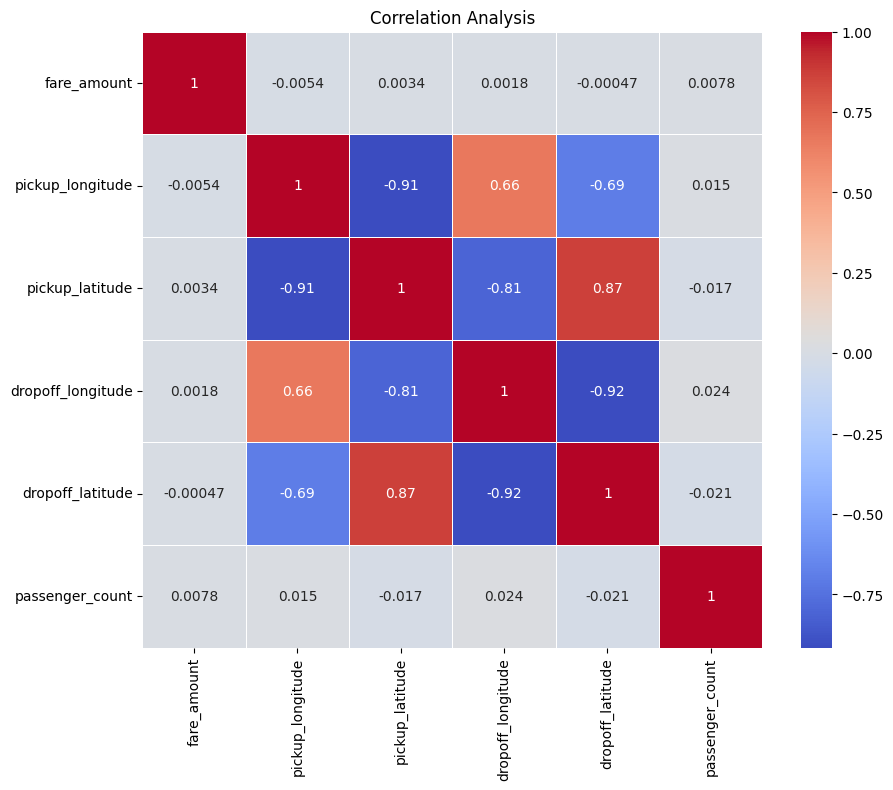

In [480]:
column = ["fare_amount","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count"]
corr = df[column].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Analysis')
plt.show()

# Fitting models

In [481]:
X = df.drop(columns=["fare_amount","key","pickup_datetime"])
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [482]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = MSE(y_test, y_pred)
    return mse

In [483]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [484]:
rf = RandomForestRegressor(n_estimators=100,random_state=9,max_features='sqrt')

dt = DecisionTreeRegressor(max_depth=10,min_samples_leaf=0.13,random_state=9)

gb = GradientBoostingRegressor(max_depth=6,n_estimators=100,random_state=9)

linr = LinearRegression()

lasso = Lasso()

ridge = Ridge(alpha=100)

In [485]:
models = [('Decision Tree Regressor', dt),('Gradient Boosting Regressor', gb),('Random Forest Regressor', rf),('Linear Regression', linr),('Lasso', lasso),('Ridge', ridge)]

mse = {}

for name,model in models:
    mse[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

mse

{'Decision Tree Regressor': np.float64(8.206651279570433),
 'Gradient Boosting Regressor': np.float64(3.388848082142449),
 'Random Forest Regressor': np.float64(2.923648844274505),
 'Linear Regression': np.float64(8.616799535313913),
 'Lasso': np.float64(8.6140701214198),
 'Ridge': np.float64(8.616759572844355)}

In [486]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=10, scoring='neg_mean_squared_error', 
                                   cv=5, random_state=42, n_jobs=-1)
                                   
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_

print("Best parameters for RandomForest:", random_search.best_params_)


/Users/softylines/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for RandomForest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


In [487]:
y_pred = best_rf.predict(X_test)
MSE(y_test, y_pred)

np.float64(2.91219261279016)

In [488]:
r_squared = rf.score(X_train, y_train)
r_squared

0.9518695284444121

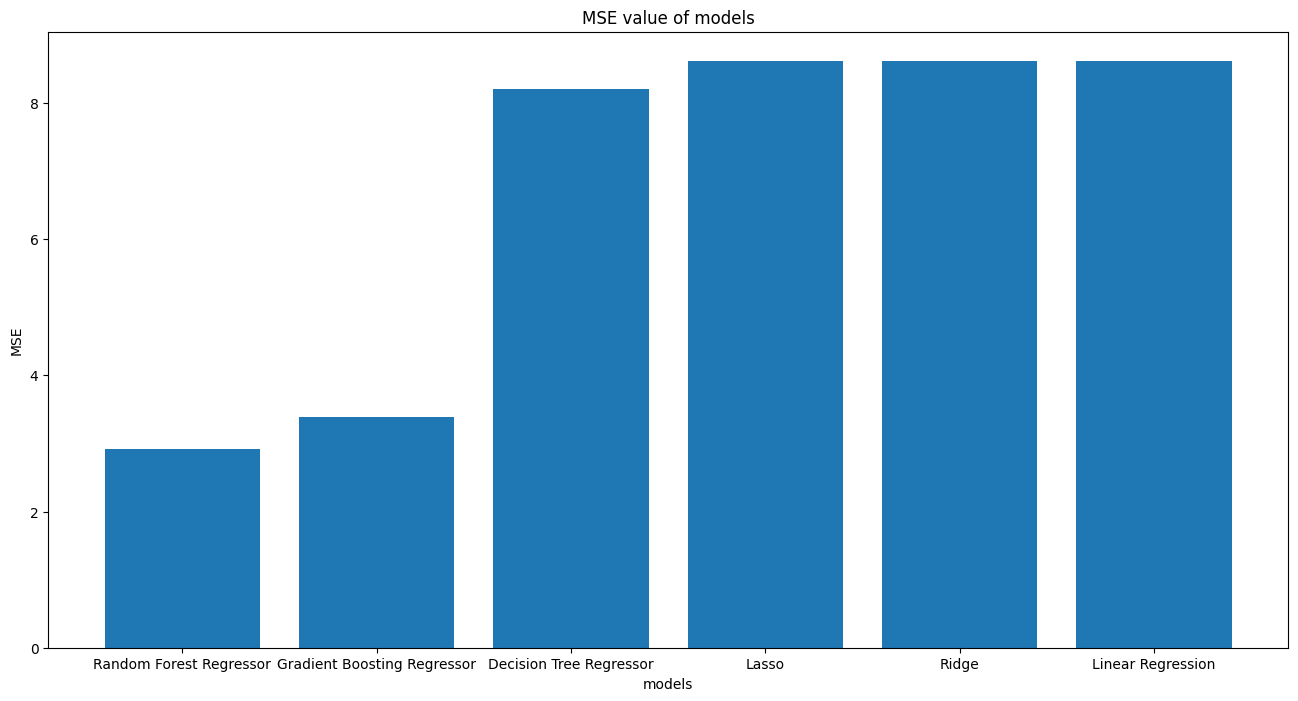

In [490]:
data = dict(sorted(mse.items(), key=lambda key_val: key_val[1]))

names = list(data.keys())
values = list(data.values())

plt.figure(figsize=(16, 8))
plt.title('MSE value of models')
plt.xlabel("models")
plt.ylabel('MSE')
plt.bar(range(len(data)), values, tick_label=names)
plt.show()

### The best model is Random Forest Regressor with MSE = 2.92